### Block 1 – Service-time model setup and sanity check

This block initializes the core batch service-time model that underlies the GPU simulator and verifies that it behaves as expected before introducing arrivals and scheduling.

---

#### Model parameters

The following constants implement the piecewise-linear latency model from the project description (Llama-3-70B example):

- `C_SETUP = 45.5` ms – fixed setup cost per batch.
- `A_MARGINAL = 0.30` ms/token – marginal cost per token beyond a threshold.
- `B0_THRESHOLD = 64` tokens – batch-size threshold `b0`.

The intended batch service time for a batch with token load `b` is

`S(b) = c + a * max(0, b - b0)`

where `c = C_SETUP`, `a = A_MARGINAL`, and `b0 = B0_THRESHOLD`.  
The implementation returns `S(b)` in seconds.

---

#### Data structures

- **Request**  
  Simple dataclass representing a single LLM query, with:
  - `arrival_time` – arrival timestamp (seconds),
  - `prompt_len` – input length in tokens,
  - `output_budget` – planned decode length in tokens,
  - tracking fields `start_time`, `finish_time`, and `tokens_generated`.

  In this block, `Request` is mainly illustrative; richer state (for TTFT and decode tokens) is introduced in later blocks.

- **GPUServer**  
  Minimal GPU worker abstraction that:
  - Stores `max_batch_size`,
  - Maintains `queue` and `active_batch` lists (placeholders for later scheduling logic),
  - Implements the batch service-time function:

    ```python
    ms_time = C_SETUP + A_MARGINAL * max(0, batch_token_load - B0_THRESHOLD)
    return ms_time / 1000.0
    ```

---

#### Sanity check of the service-time model

At the end of the block, a small diagnostic is performed:

- Instantiate `GPUServer(max_batch_size=8)`.
- Evaluate `calc_service_time` for several batch token loads:

  ```python
  test_loads = [10, 64, 100, 500]


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Optional

# Setup cost (ms), Marginal cost (ms/token), Batch threshold
C_SETUP = 45.5
A_MARGINAL = 0.30
B0_THRESHOLD = 64

@dataclass
class Request:
    """
    Represents a single LLM query (User Job).
    Tracks its lifecycle statistics for output analysis.
    """
    req_id: int
    arrival_time: float
    prompt_len: int      # Tokens in input
    output_budget: int   # Tokens to generate

    # Tracking Metrics
    start_time: float = -1.0
    finish_time: float = -1.0
    tokens_generated: int = 0

    def remaining_tokens(self) -> int:
        return self.output_budget - self.tokens_generated

class GPUServer:
    """
    Represents the GPU Worker.
    Manages the queue and calculates service times based on the
    piecewise linear model S(b) = c + a * max(0, b - b0).
    """
    def __init__(self, max_batch_size: int):
        self.max_batch_size = max_batch_size
        self.queue: List[Request] = [] # The waiting line
        self.active_batch: List[Request] = [] # Jobs currently on GPU
        self.is_busy: bool = False

    def calc_service_time(self, batch_token_load: int) -> float:
        """
        Calculates processing time in SECONDS.
        Formula: c + a * max(0, b - b0) (from project specs)
        """
        ms_time = C_SETUP + A_MARGINAL * max(0, batch_token_load - B0_THRESHOLD)
        return ms_time / 1000.0  # Convert ms to seconds

    def add_to_queue(self, req: Request):
        self.queue.append(req)

# --- Validation of "Physics" ---
# Let's test if the service time calculation matches the linear model expectation.
# This serves as a sanity check before building the complex loop.

server = GPUServer(max_batch_size=8)
test_loads = [10, 50, 100, 500]

print("--- Service Model Validation ---")
print(f"Parameters: c={C_SETUP}ms, a={A_MARGINAL}ms/tok, b0={B0_THRESHOLD}")
for load in test_loads:
    duration = server.calc_service_time(load)
    print(f"Token Load: {load:3d} -> Service Time: {duration:.4f} sec")

--- Service Model Validation ---
Parameters: c=45.5ms, a=0.3ms/tok, b0=64
Token Load:  10 -> Service Time: 0.0455 sec
Token Load:  50 -> Service Time: 0.0455 sec
Token Load: 100 -> Service Time: 0.0563 sec
Token Load: 500 -> Service Time: 0.1763 sec


### Block 2 – Simulation engine and baseline scheduling policy

This block implements the core **discrete-event simulation** of a single-GPU LLM server.  
It adds an arrival process, a simple scheduling policy, and per-request latency metrics on top of the batch service-time model from Block 1.

---

#### Configuration and state

- Global parameters (units as in the handout):
  - `DEFAULT_C`, `DEFAULT_A`, `DEFAULT_B0` – default values for `c`, `a`, and `b0`.
  - `CURRENT_C`, `CURRENT_B0` – mutable versions used in `calc_service_time`.  
    These are overridden in the validation block to emulate an M/M/1 system.

- `Request` dataclass:
  - Fields:
    - `req_id` – integer request identifier,
    - `arrival_time` – arrival timestamp (seconds),
    - `prompt_len` – prompt length `L_i` (tokens),
    - `output_budget` – output budget `B_i` (tokens),
    - `start_time` – time when the request first enters a GPU batch,
    - `finish_time` – completion time,
    - `tokens_decoded` – number of decode tokens produced so far.
  - Property:
    - `is_complete` – `True` once `tokens_decoded >= output_budget`.

- `GPUServer`:
  - Stores `max_batch_size` (number of jobs per batch).
  - Maintains:
    - `queue` – FCFS waiting line,
    - `active_batch` – set of requests currently on the GPU.
  - Method:
    - `calc_service_time(batch_token_load)` – computes service time in seconds via  
      `ms_time = CURRENT_C + DEFAULT_A * max(0, batch_token_load - CURRENT_B0)`  
      followed by division by 1000.

---

#### Arrival process and job sizes

Function: `run_simulation(arrival_rate_lambda, max_duration, batch_size, fixed_prompt_len=None, fixed_output_len=None)`

- Arrival process:
  - Uses a Poisson process with rate `lambda` (`arrival_rate_lambda`).
  - Interarrival times are drawn as `Exp(lambda)` using `random.expovariate`.
  - Requests are generated until `t >= max_duration`.

- Job size generation:
  - If `fixed_prompt_len` / `fixed_output_len` are provided, all jobs are identical in size  
    (used in the validation block).
  - Otherwise:
    - `prompt_len` is drawn uniformly from `[50, 200]` tokens,
    - `output_budget` is fixed at 20 tokens (baseline choice for the demo).

All generated requests are stored in `all_requests`, sorted implicitly by arrival time.

---

#### Event loop and scheduling logic

The main loop runs while either:
- the simulation time `current_time` is less than `max_duration`, or
- there are still jobs in `active_batch`.

Within the loop:

1. **Admission**  
   - All jobs with `arrival_time <= current_time` are moved from `all_requests` into `server.queue`.
   - This implements an FCFS waiting line.

2. **Idle jump**  
   - If both `active_batch` and `queue` are empty but more arrivals exist,  
     `current_time` is advanced to the next arrival time.  
   - If there are no active jobs and no future arrivals, the simulation terminates.

3. **Batch formation (FCFS)**  
   - While `queue` is non-empty and `active_batch` has capacity `< max_batch_size`,  
     the earliest request is popped from `queue`, `start_time` is set to `current_time`,  
     and the request is appended to `active_batch`.

4. **Service step: prefill vs decode**

   - `needs_prefill = any(r.tokens_decoded == 0 for r in batch)`.

   - **Prefill phase** (at least one request not yet prefills):
     - Batch token load `b` is computed as the sum of `prompt_len` over `batch`.
     - Service time is `calc_service_time(b)`; `current_time` is advanced by this amount.
     - All requests with `tokens_decoded == 0` are marked as having produced their first token by setting `tokens_decoded = 1`.  
       (This models the first decode token becoming available immediately after prefill.)

   - **Decode phase** (all requests already prefills):
     - Batch token load is `len(batch)` (one token per active request).
     - Service time is `calc_service_time(len(batch))`; `current_time` is advanced.
     - Each request in `batch` increments `tokens_decoded` by 1.
     - Requests for which `is_complete` becomes `True` record `finish_time = current_time` and are removed from `active_batch`.

This yields a **batched prefill + round-robin decode** scheduling policy:
- Prefill is batched over all active queries.
- Decode produces one token per request per decode step, shared across the batch.

---

#### Output metrics

After the event loop finishes, the function assembles a `pandas.DataFrame` with one row per completed request:

- `Request ID` – identifier,
- `Arrival` – arrival time,
- `Finish` – completion time,
- `Latency` – total response time `Finish - Arrival`,
- `TTFT` – approximated as `start_time - arrival_time` (queueing delay plus scheduling delay up to first GPU service).

These fields feed into the visualization block (histograms and throughput plots) and provide the basic metrics required for the demo: latency distribution and an approximation of TTFT.


In [2]:
# Reproducibility for the demo
random.seed(0)
np.random.seed(0)

# --- Constants from Project Description ---
C_SETUP = 45.5        # ms (setup time per batch)
A_MARGINAL = 0.30     # ms/token beyond threshold
B0_THRESHOLD = 64     # tokens (batch-size threshold)



@dataclass
class Request:
    """
    Represents a single LLM query (user job).
    All times are in SECONDS.
    """
    req_id: int
    arrival_time: float
    prompt_len: int      # L_i: tokens in the input prompt
    output_budget: int   # B_i: max response length (tokens)

    # State tracking
    start_time: float = -1.0
    finish_time: float = -1.0
    tokens_decoded: int = 0
    first_token_time: float = -1.0  # for TTFT

    @property
    def is_complete(self) -> bool:
        return self.tokens_decoded >= self.output_budget

class GPUServer:
    """
    Single GPU worker with batched processing.
    """
    def __init__(self, max_batch_size: int):
        self.max_batch_size = max_batch_size
        self.queue: List[Request] = []
        self.active_batch: List[Request] = []

    def calc_service_time(self, batch_token_load: int) -> float:
        """
        Calculates processing time in SECONDS using:
            S(b) = c + a * max(0, b - b0)
        where b is the batch token load.
        """
        ms_time = C_SETUP + A_MARGINAL * max(0, batch_token_load - B0_THRESHOLD)
        return ms_time / 1000.0  # convert ms -> seconds

def run_simulation(arrival_rate_lambda: float = 1.0,
                   max_duration: float = 60.0,
                   max_batch_size: int = 4) -> pd.DataFrame:
    """
    Runs a discrete-event simulation for a single-GPU batched LLM server.

    Scheduling:
      - FCFS admission into batches up to max_batch_size
      - Prefill: batched over all jobs that have not been prefills yet
      - Decode: round-robin, 1 token per job in the active batch per step

    Returns:
      DataFrame with per-request metrics including TTFT and avg TBT.
    """
    server = GPUServer(max_batch_size=max_batch_size)
    current_time = 0.0
    completed_requests: List[Request] = []

    # --- Generate arrivals (Poisson process) ---
    all_requests: List[Request] = []
    t = 0.0
    req_id = 0

    B_MAX = 32      # cap for output budget
    p_geom = 0.15   # geometric parameter for B_i

    while t < max_duration:
        dt = random.expovariate(arrival_rate_lambda)
        t += dt
        if t >= max_duration:
            break

        # Prompt length L_i (simple uniform for now)
        prompt_len = random.randint(50, 200)

        # Output budget B_i ~ Geometric(p), capped at B_MAX
        raw_length = np.random.geometric(p_geom)  # 1, 2, ...
        output_budget = int(min(max(raw_length, 1), B_MAX))

        r = Request(
            req_id=req_id,
            arrival_time=t,
            prompt_len=prompt_len,
            output_budget=output_budget
        )
        all_requests.append(r)
        req_id += 1

    print(f"--- Simulation Started: {len(all_requests)} requests generated ---")

    arrival_index = 0

    # --- Main simulation loop ---
    while current_time < max_duration or server.active_batch:
        # Admit arrivals whose arrival_time <= current_time
        while arrival_index < len(all_requests):
            next_req = all_requests[arrival_index]
            if next_req.arrival_time <= current_time:
                server.queue.append(next_req)
                arrival_index += 1
            else:
                break

        # If system idle and more arrivals in future, jump to next arrival
        if not server.active_batch and not server.queue and arrival_index < len(all_requests):
            current_time = all_requests[arrival_index].arrival_time
            continue

        # If system empty and no more arrivals, stop
        if not server.active_batch and not server.queue and arrival_index >= len(all_requests):
            break

        # Fill active batch (FCFS) up to max_batch_size
        while server.queue and len(server.active_batch) < server.max_batch_size:
            req = server.queue.pop(0)
            if req.start_time < 0:
                req.start_time = current_time
            server.active_batch.append(req)

        batch = server.active_batch
        if not batch:
            continue

        # Decide between PREFILL vs DECODE
        needs_prefill = any(r.tokens_decoded == 0 for r in batch)

        if needs_prefill:
            # --- PREFILL PHASE ---
            # Only count prompts for requests that still need prefill
            batch_load = sum(r.prompt_len for r in batch if r.tokens_decoded == 0)
            step_duration = server.calc_service_time(batch_load)
            prefill_end_time = current_time + step_duration
            current_time = prefill_end_time

            for r in batch:
                if r.tokens_decoded == 0:
                    # First token becomes available right after prefill
                    r.tokens_decoded = 1
                    if r.first_token_time < 0:
                        r.first_token_time = prefill_end_time
        else:
            # --- DECODE PHASE ---
            # One token per request in the batch
            batch_load = len(batch)
            step_duration = server.calc_service_time(batch_load)
            current_time += step_duration

            finished_indices = []
            for i, r in enumerate(batch):
                r.tokens_decoded += 1
                if r.is_complete:
                    r.finish_time = current_time
                    completed_requests.append(r)
                    finished_indices.append(i)

            # Remove completed jobs from the active batch
            for i in sorted(finished_indices, reverse=True):
                server.active_batch.pop(i)

    # --- Compile per-request metrics ---
    results = []
    for r in completed_requests:
        # Time To First Token (TTFT)
        if r.first_token_time > 0:
            ttft = r.first_token_time - r.arrival_time
        else:
            ttft = None

        # Total completion latency (arrival -> last token)
        completion_latency = r.finish_time - r.arrival_time

        # Average Time Between Tokens (from first to last)
        if r.first_token_time > 0 and r.output_budget > 1:
            avg_tbt = (r.finish_time - r.first_token_time) / (r.output_budget - 1)
        else:
            avg_tbt = None

        results.append({
            "request_id": r.req_id,
            "arrival_time": r.arrival_time,
            "first_token_time": r.first_token_time,
            "completion_time": r.finish_time,
            "completion_latency": completion_latency,  # end-to-end latency
            "TTFT": ttft,                               # Time To First Token
            "avg_TBT": avg_tbt,                         # average Time Between Tokens
            "output_tokens": r.output_budget
        })

    return pd.DataFrame(results)

# Quick test run for the demo
df_results = run_simulation(arrival_rate_lambda=2.0, max_duration=10.0, max_batch_size=4)
print("\n--- Simulation Complete ---")
print(df_results.head().to_string(index=False))


--- Simulation Started: 12 requests generated ---

--- Simulation Complete ---
 request_id  arrival_time  first_token_time  completion_time  completion_latency     TTFT  avg_TBT  output_tokens
          0      0.930304          1.003704         1.266004            0.335700 0.073400 0.065575              5
          1      0.950967          1.084004         1.466904            0.515937 0.133037 0.054700              8
          2      1.283663          1.375904         1.603404            0.319741 0.092241 0.045500              6
          3      3.001557          3.070157         3.252157            0.250600 0.068600 0.045500              5
          4      3.439350          3.497150         3.633650            0.194300 0.057800 0.045500              4


### Block 3 – Visualization: latency distribution and throughput

This block generates basic visual metrics from the simulation output.  
It operates on the `pandas.DataFrame` returned by `run_simulation`, which contains per-request fields:

- `TTFT` – time from arrival until first service (Time To First Token approximation),
- `Latency` – total response time (completion time minus arrival time),
- `Finish` – completion time of each request.

---

#### Latency distribution

The first subplot produces overlaid histograms of:

- `TTFT`
- `Latency` (total completion latency)

using 15 bins each. This plot summarizes the distribution of user-visible delays:

- how quickly the first token is seen (TTFT),
- how long it takes to receive the full response (total latency).

The plot title and legend explicitly distinguish between these two latency notions.

---

#### Throughput over time

The second subplot estimates **throughput** as requests completed per second:

- The time axis is partitioned into 5-second windows from 0 up to `max_t = df["Finish"].max()`.
- For each window, the number of completions is counted via `np.histogram(df["Finish"], bins=bins)`.
- Counts are divided by the window length (5 seconds) to obtain an average **requests per second** rate for each interval.
- The result is plotted as a line (`counts / 5.0` versus the left edge of each time bin).

This shows how the system’s completion rate evolves over the course of the simulation (e.g., warm-up vs. steady state behavior).


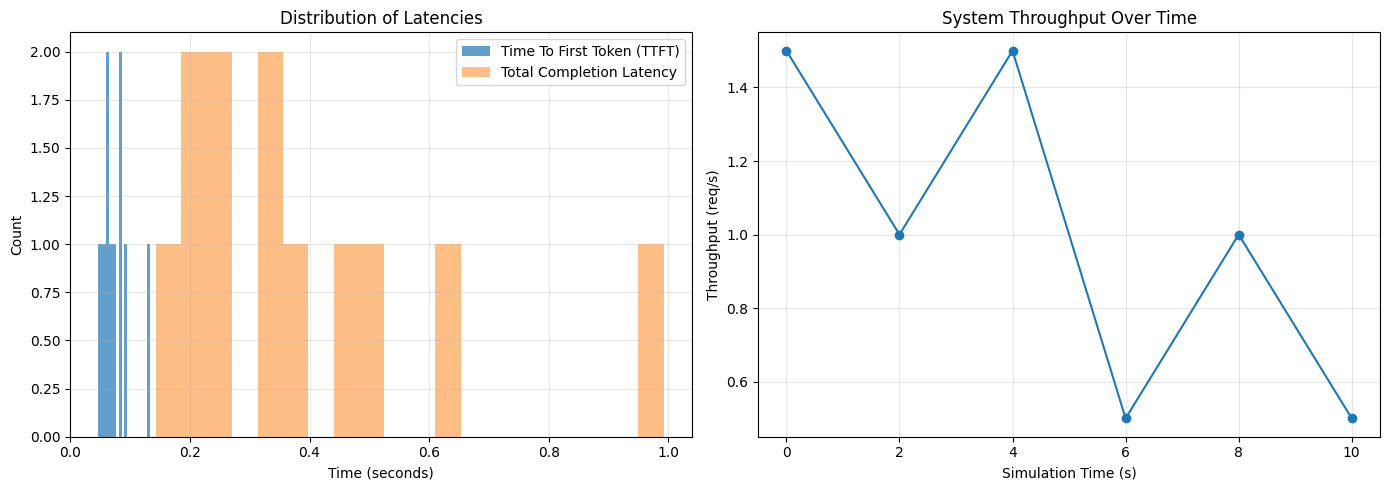


--- Summary Metrics ---
Mean TTFT:           0.0732 s
Mean total latency:  0.3926 s
P95 total latency:   0.8050 s
Total throughput:    1.18 req/s
Mean avg_TBT:        0.0486 s


In [3]:
# --- VISUALIZATION BLOCK ---
def plot_results(df):
    """
    Generates the plots for the demo:
    1. Latency histogram (TTFT and total completion latency)
    2. Throughput over time (requests completed per second)
    """
    if df.empty:
        print("No data to plot.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Latency Distribution (TTFT vs Total Latency)
    ttft_vals = df["TTFT"].dropna()
    total_lat = df["completion_latency"].dropna()

    axes[0].hist(ttft_vals, bins=20, alpha=0.7, label="Time To First Token (TTFT)")
    axes[0].hist(total_lat, bins=20, alpha=0.5, label="Total Completion Latency")
    axes[0].set_xlabel("Time (seconds)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Distribution of Latencies")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Throughput (requests completed per 2-second window)
    max_time = df["completion_time"].max()
    time_bins = np.arange(0, max_time + 2, 2)  # 2-second windows
    throughput_counts, _ = np.histogram(df["completion_time"], bins=time_bins)

    # Convert counts to Requests Per Second (divide by window size = 2s)
    throughput_rps = throughput_counts / 2.0

    axes[1].plot(time_bins[:-1], throughput_rps, marker="o", linestyle="-")
    axes[1].set_xlabel("Simulation Time (s)")
    axes[1].set_ylabel("Throughput (req/s)")
    axes[1].set_title("System Throughput Over Time")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print Summary Stats
    print("\n--- Summary Metrics ---")
    print(f"Mean TTFT:           {ttft_vals.mean():.4f} s")
    print(f"Mean total latency:  {total_lat.mean():.4f} s")
    print(f"P95 total latency:   {total_lat.quantile(0.95):.4f} s")
    print(f"Total throughput:    {len(df) / max_time:.2f} req/s")

    # Optional: TBT summary if you want to mention it
    if "avg_TBT" in df.columns:
        avg_tbt_vals = df["avg_TBT"].dropna()
        if not avg_tbt_vals.empty:
            print(f"Mean avg_TBT:        {avg_tbt_vals.mean():.4f} s")

# Run the visualizer on your previous results
plot_results(df_results)


### Block 4 – Validation against M/M/1 queueing theory

This block provides a **model validation step** by specializing the simulator to a simple setting where classical queueing theory applies, and comparing simulated latencies to the M/M/1 closed-form expression.

---

#### Goal

Show that, in a simplified configuration with:

- a single server (single GPU),
- no batching,
- no setup cost,
- constant job sizes (hence constant service time),

the simulator produces a mean response time that is consistent with the **M/M/1** result:

`E[T] = 1 / (μ - λ)`

where `λ` is the arrival rate and `μ` is the service rate.

This corresponds to the “compare to M/M/1” validation idea in the project description.

---

#### Step 1 – Override service-time “physics”

Function: `run_mm1_validation()`

Inside this function, the batch service model is simplified:

- `CURRENT_C = 0.0` – removes the per-batch setup cost `c`.
- `CURRENT_B0 = 0` – removes the batch-size threshold `b0`.

With these settings, the service time in `calc_service_time` becomes

`S(b) = A_MARGINAL * b`

and, with `batch_size = 1`, each request is processed as a single “batch” with a fixed token count.

---

#### Step 2 – Fix job size and compute μ

Parameters:

- Arrival rate `λ = lam = 5.0` (queries per second).
- Job structure:
  - `prompt_len = 100` tokens,
  - `decode_len = 1` token,
  - `total_tokens = 101`.

The average service time per job (in seconds) is:

```python
avg_service_time = (DEFAULT_A * total_tokens) / 1000.0
mu = 1.0 / avg_service_time



=== VALIDATION: M/M/1 COMPARISON ===
Theory: lambda = 5.00, mu = 33.00
Expected mean response time (M/M/1): 0.0357 sec
Simulated mean latency (N=10069):  0.1542 sec
=== VALIDATION COMPLETE ===

=== RUNNING MAIN DEMO (Realistic) ===
   Request ID   Arrival    Finish   Latency      TTFT
0           0  0.479041  1.488241  1.009200  0.000000
1           1  1.167108  2.125241  0.958133  0.004933
2           2  2.590551  3.797351  1.206800  0.000000
3           3  2.672334  3.842851  1.170517  0.040717
4           4  2.810005  3.842851  1.032846  0.012146


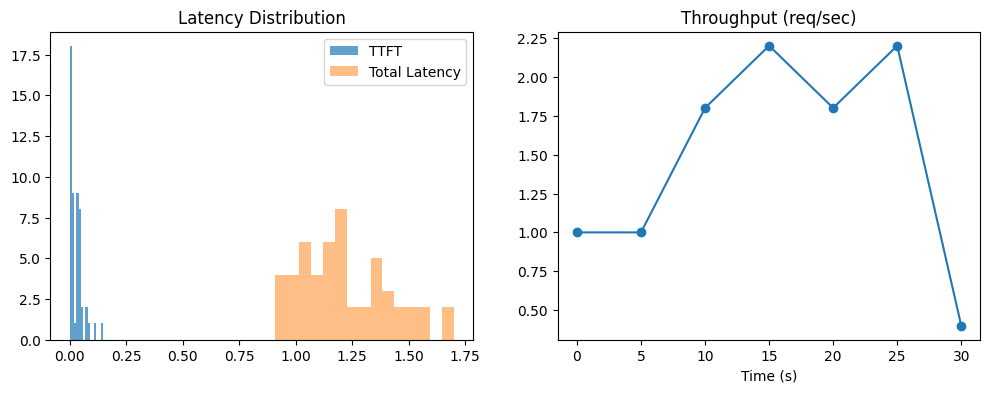

In [4]:
# --- 1. CONFIGURATION & CLASSES ---
# Default Configuration (Llama-3-70B values from text)
DEFAULT_C = 45.5   # ms setup
DEFAULT_A = 0.30   # ms/token marginal
DEFAULT_B0 = 64    # batch threshold

# Global settings we can override for validation
CURRENT_C = DEFAULT_C
CURRENT_B0 = DEFAULT_B0



# --- 2. THE SIMULATION ENGINE ---
def run_simulation(arrival_rate_lambda=1.0,
                   max_duration=60.0,
                   batch_size=4,
                   fixed_prompt_len: Optional[int] = None,
                   fixed_output_len: Optional[int] = None):
    """
    Runs the simulation.
    If fixed_prompt_len is set, generates deterministic job sizes (good for validation).
    """
    server = GPUServer(max_batch_size=batch_size)
    current_time = 0.0
    completed_requests = []

    # Pre-generate arrivals
    all_requests = []
    t = 0
    req_id = 0
    while t < max_duration:
        t += random.expovariate(arrival_rate_lambda)
        if t >= max_duration: break

        # Determine sizes
        p_len = fixed_prompt_len if fixed_prompt_len else random.randint(50, 200)
        o_len = fixed_output_len if fixed_output_len else 20

        all_requests.append(Request(req_id, t, p_len, o_len))
        req_id += 1

    arrival_index = 0

    # Event Loop
    while current_time < max_duration or server.active_batch:

        # Admission
        while arrival_index < len(all_requests):
            if all_requests[arrival_index].arrival_time <= current_time:
                server.queue.append(all_requests[arrival_index])
                arrival_index += 1
            else:
                break

        # Idle Jump
        if not server.active_batch and not server.queue and arrival_index < len(all_requests):
            current_time = all_requests[arrival_index].arrival_time
            continue
        elif not server.active_batch and not server.queue:
            break

        # Fill Batch
        while server.queue and len(server.active_batch) < server.max_batch_size:
            req = server.queue.pop(0)
            req.start_time = current_time
            server.active_batch.append(req)

        # Processing
        batch = server.active_batch
        if not batch: continue

        needs_prefill = any(r.tokens_decoded == 0 for r in batch)

        if needs_prefill:
            # Prefill Step
            load = sum(r.prompt_len for r in batch)
            current_time += server.calc_service_time(load)
            for r in batch:
                if r.tokens_decoded == 0: r.tokens_decoded = 1
        else:
            # Decode Step
            current_time += server.calc_service_time(len(batch))

            finished_indices = []
            for i, r in enumerate(batch):
                r.tokens_decoded += 1
                if r.is_complete:
                    r.finish_time = current_time
                    completed_requests.append(r)
                    finished_indices.append(i)

            for i in sorted(finished_indices, reverse=True):
                server.active_batch.pop(i)

    # DataFrame
    data = []
    for r in completed_requests:
        data.append({
            "Request ID": r.req_id,
            "Arrival": r.arrival_time,
            "Finish": r.finish_time,
            "Latency": r.finish_time - r.arrival_time,
            "TTFT": (r.start_time - r.arrival_time)
        })
    return pd.DataFrame(data)

# --- 3. VISUALIZATION ---
def plot_demo_metrics(df):
    if df.empty: return
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram
    ax1.hist(df['TTFT'], bins=15, alpha=0.7, label='TTFT')
    ax1.hist(df['Latency'], bins=15, alpha=0.5, label='Total Latency')
    ax1.set_title("Latency Distribution")
    ax1.legend()

    # Throughput
    max_t = df['Finish'].max()
    bins = np.arange(0, max_t + 5, 5)
    counts, _ = np.histogram(df['Finish'], bins=bins)
    ax2.plot(bins[:-1], counts/5.0, marker='o')
    ax2.set_title("Throughput (req/sec)")
    ax2.set_xlabel("Time (s)")
    plt.show()

# --- 4. VALIDATION (M/M/1 Check) ---
def run_mm1_validation():
    print("\n=== VALIDATION: M/M/1 COMPARISON ===")

    # 1. Override physics for M/M/1-like behavior
    # No setup cost, purely linear service time in tokens
    global CURRENT_C, CURRENT_B0
    CURRENT_C = 0.0
    CURRENT_B0 = 0

    # 2. Parameters
    lam = 5.0   # arrival rate (lambda)

    # Fix job size so service rate (mu) is constant
    # Job = 100 prompt tokens + 1 decode token -> 101 tokens total
    prompt_len = 100
    decode_len = 1
    total_tokens = prompt_len + decode_len

    # Service time per job = a * total_tokens / 1000 (seconds)
    avg_service_time = (DEFAULT_A * total_tokens) / 1000.0
    mu = 1.0 / avg_service_time

    print(f"Theory: lambda = {lam:.2f}, mu = {mu:.2f}")
    if lam >= mu:
        print("Warning: lambda >= mu, system is unstable in M/M/1 theory.")
    else:
        # M/M/1 mean response time (arrival -> departure):
        theo_response_time = 1.0 / (mu - lam)
        print(f"Expected mean response time (M/M/1): {theo_response_time:.4f} sec")

    # 3. Run simulation with batch_size = 1 (strict FCFS, no batching)
    df = run_simulation(
        arrival_rate_lambda=lam,
        max_duration=2000,       # long run to approximate steady state
        batch_size=1,
        fixed_prompt_len=prompt_len,
        fixed_output_len=decode_len
    )

    sim_mean_latency = df["Latency"].mean()
    print(f"Simulated mean latency (N={len(df)}):  {sim_mean_latency:.4f} sec")

    # 4. Restore defaults
    CURRENT_C = DEFAULT_C
    CURRENT_B0 = DEFAULT_B0
    print("=== VALIDATION COMPLETE ===\n")


# ==========================================
# EXECUTE DEMO
# ==========================================

# 1. Run Validation
run_mm1_validation()

# 2. Run Main Demo (Realistic Params)
print("=== RUNNING MAIN DEMO (Realistic) ===")
df_main = run_simulation(arrival_rate_lambda=2.0, max_duration=30.0, batch_size=8)
print(df_main.head())
plot_demo_metrics(df_main)

### Block 5- Scheduling Policies and Tradeoffs

In this section, we compare two simple scheduling policies on top of the same
physics model (Poisson arrivals, Llama-style batch service time
\\(S(b) = c + a \max(0, b - b_0)\\)):

1. **Process-to-Completion (P2C, no batching)**  
   - The GPU always picks the earliest-arrived job from the queue and processes
     it **alone** until its entire response is done.  
   - This corresponds to a simple “each query runs to completion” baseline
     without any batching or prefill/decode structure.
   - Intuition: good for *simplicity*, but wastes GPU parallelism and tends
     to have **poor throughput**.

2. **Prefill-Prioritizing Batched Decode (PPB)**  
   - Queries arrive over time and are collected into **batches** up to
     `max_batch_size`.
   - For each batch, we first run a **prefill phase** on all prompts in the
     batch (prompt lengths \\(L_i\\)), then enter a **decode phase** where we
     generate **one token per request per decode step** until all outputs
     finish.
   - All service is modeled through the same batch latency function
     \\(S(b) = c + a \max(0, b - b_0)\\), where \\(b\\) is the total token
     load in the batch step.
   - Intuition: exploits GPU parallelism, so **throughput** is higher.
     However, batching and prefill phases can increase TTFT for some users.

For a clean apples-to-apples comparison, we consider a simple homogeneous
setting:

- Single GPU worker
- Single job type:
  - Prompt length \\(L = L_0\\) (fixed)
  - Output length \\(B = B_0\\) (fixed)
- Poisson arrivals with rate \\(\lambda\\)
- Same service-time physics \\(S(b)\\) used in earlier sections.

We measure, for each policy and arrival rate \\(\lambda\\):

- **TTFT** (Time to First Token)
- **Total latency** (completion time – arrival time)
- **Average TBT** (time between output tokens)
- **Throughput** in completed requests / second

Below we define a lightweight simulator for these two policies and then run
experiments across a grid of arrival rates.

<>:325: SyntaxWarning: invalid escape sequence '\l'
<>:336: SyntaxWarning: invalid escape sequence '\l'
<>:346: SyntaxWarning: invalid escape sequence '\l'
<>:350: SyntaxWarning: invalid escape sequence '\l'
<>:325: SyntaxWarning: invalid escape sequence '\l'
<>:336: SyntaxWarning: invalid escape sequence '\l'
<>:346: SyntaxWarning: invalid escape sequence '\l'
<>:350: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3333525878.py:325: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Arrival rate $\lambda$ (req/s)")
/tmp/ipython-input-3333525878.py:336: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Arrival rate $\lambda$ (req/s)")
/tmp/ipython-input-3333525878.py:346: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel("Arrival rate $\lambda$ (req/s)")
/tmp/ipython-input-3333525878.py:350: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(summary_df["lambda"].unique(), summary_df["lambda"].unique(), linestyle=':', color='gray', label

=== Policy Comparison Summary (policy_comparison_summary.csv) ===
 lambda policy  mean_TTFT  p95_TTFT  mean_Latency  p95_Latency  mean_avg_TBT  Throughput  num_completed
    0.5    P2C     0.0536    0.0527        0.0620       0.0611        0.0006      0.5102           2000
    0.5    PPB     0.0636    0.0969        0.7662       0.8514        0.0468      0.4923           2000
    1.0    P2C     0.0547    0.0645        0.0631       0.0729        0.0006      0.9848           2000
    1.0    PPB     0.0690    0.0990        0.7928       0.8929        0.0483      0.9806           2000
    1.5    P2C     0.0555    0.0789        0.0639       0.0873        0.0006      1.4638           2000
    1.5    PPB     0.0736    0.1030        0.8179       0.9410        0.0496      1.4475           2000
    2.0    P2C     0.0565    0.0905        0.0650       0.0989        0.0006      1.9618           2000
    2.0    PPB     0.0770    0.1067        0.8472       1.0029        0.0513      1.9796           200

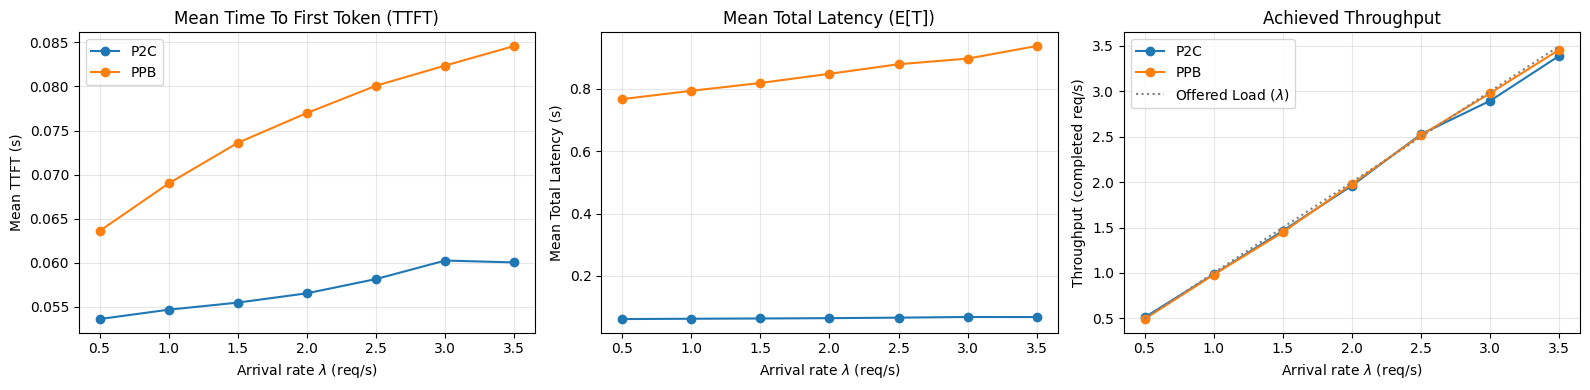

In [14]:
# Batch service time S(b) in seconds for a batch with `batch_token_load` tokens.
def batch_service_time_seconds(batch_token_load):
    """Calculates processing time in SECONDS."""
    ms_time = C_SETUP + A_MARGINAL * max(0, batch_token_load - B0_THRESHOLD)
    return ms_time / 1000.0  # convert milliseconds -> seconds

@dataclass
class SimpleRequest:
    req_id: int
    arrival_time: float
    prompt_len: int
    output_len: int
    first_token_time: float | None = None
    finish_time: float | None = None
    decoded_tokens: int = 0


def generate_homogeneous_requests(
    lam: float,
    num_jobs: int,
    prompt_len: int,
    output_len: int,
    seed: int | None = None,
) -> list[SimpleRequest]:
    """
    Generate `num_jobs` Poisson arrivals with rate lam, all with the same
    prompt_len and output_len.
    """
    rng = random.Random(seed)
    t = 0.0
    requests: list[SimpleRequest] = []
    for j in range(num_jobs):
      t += rng.expovariate(lam)
      requests.append(SimpleRequest(j, t, prompt_len, output_len))
    return requests


# -------------------- Policy 1: Process-to-Completion (P2C) --------------------

def simulate_p2c(
    lam: float,
    num_jobs: int,
    prompt_len: int,
    output_len: int,
    seed: int | None = None,
) -> tuple[pd.DataFrame, float]:
    """
    Single-server FCFS system.
    Each request runs to completion alone; modeled as a single batch
    with token load L + B.

    Returns:
        df: per-request metrics
        sim_length: total simulated time (last_finish - first_arrival)
    """
    requests = generate_homogeneous_requests(
        lam=lam,
        num_jobs=num_jobs,
        prompt_len=prompt_len,
        output_len=output_len,
        seed=seed,
    )
    if not requests:
        return pd.DataFrame(), 0.0

    server_free_time = 0.0
    first_arrival = requests[0].arrival_time
    last_finish = first_arrival

    for r in requests:
        start_service = max(r.arrival_time, server_free_time)
        total_tokens = r.prompt_len + r.output_len
        service_time = batch_service_time_seconds(total_tokens)

        # Heuristic: TTFT = time to "prefill" the prompt fraction
        prefill_time = service_time * (r.prompt_len / total_tokens)
        r.first_token_time = start_service + prefill_time

        r.finish_time = start_service + service_time
        r.decoded_tokens = r.output_len

        server_free_time = r.finish_time
        last_finish = max(last_finish, r.finish_time)

    sim_length = max(last_finish - first_arrival, 1e-9)

    rows = []
    for r in requests:
        ttft = r.first_token_time - r.arrival_time
        latency = r.finish_time - r.arrival_time

        # Make avg_TBT definition consistent with PPB:
        # total decode duration / (output_len - 1)
        if r.output_len > 1:
            avg_tbt = (r.finish_time - r.first_token_time) / (r.output_len - 1)
        else:
            avg_tbt = 0.0

        rows.append(
            {
                "policy": "P2C",
                "req_id": r.req_id,
                "arrival": r.arrival_time,
                "TTFT": ttft,
                "Latency": latency,
                "avg_TBT": avg_tbt,
            }
        )

    df = pd.DataFrame(rows)
    return df, sim_length

# -------- Policy 2: Prefill-Prioritizing Batched Decode (PPB) --------

def simulate_ppb(
    lam: float,
    num_jobs: int,
    prompt_len: int,
    output_len: int,
    max_batch_size: int = 8,
    seed: int | None = None,
) -> tuple[pd.DataFrame, float]:
    """
    Prefill-prioritizing batched decode (Discrete Event Simulation).
    """
    rng = random.Random(seed)
    requests = generate_homogeneous_requests(
        lam=lam,
        num_jobs=num_jobs,
        prompt_len=prompt_len,
        output_len=output_len,
        seed=seed,
    )
    if not requests:
        return pd.DataFrame(), 0.0

    t = 0.0
    arrival_index = 0
    N = len(requests)

    # State tracking
    prefill_queue: list[SimpleRequest] = []
    decode_jobs: list[SimpleRequest] = []

    first_arrival = requests[0].arrival_time
    last_finish = first_arrival

    while arrival_index < N or prefill_queue or decode_jobs:

        # 1. Idle jump / Admit arrivals
        if not prefill_queue and not decode_jobs and arrival_index < N:
            t = max(t, requests[arrival_index].arrival_time)

        # Admit all arrivals that have occurred up to the current time t
        while (arrival_index < N and requests[arrival_index].arrival_time <= t):
            prefill_queue.append(requests[arrival_index])
            arrival_index += 1

        # Check termination condition
        if not prefill_queue and not decode_jobs and arrival_index >= N:
            break

        # If both queues are empty, but more arrivals are scheduled (t < max_duration equivalent in the grid run)
        if not prefill_queue and not decode_jobs and arrival_index < N:
            continue

        # 2. Scheduling Logic (Prioritize Prefill)
        if prefill_queue:
            # --- PREFILL PHASE ---
            # Max K requests can be prefills at a time (implicit batch size K)
            batch = prefill_queue[:max_batch_size]
            prefill_queue = prefill_queue[max_batch_size:]

            batch_tokens = sum(r.prompt_len for r in batch)
            step_time = batch_service_time_seconds(batch_tokens)

            t += step_time

            for r in batch:
                r.decoded_tokens = 1 # First token generated
                if r.first_token_time is None:
                     r.first_token_time = t
                # Move request to the decode pool
                decode_jobs.append(r)

            # Since prefill is prioritized, we loop back to check if we can run another prefill batch
            continue

        # 3. DECODE phase (only runs if prefill_queue is empty)
        if decode_jobs:
            # Active jobs are those that are not yet complete
            active = [r for r in decode_jobs if r.decoded_tokens < r.output_len]
            if not active:
                decode_jobs = [] # Clean up the list
                continue

            # Batch up to max_batch_size decode jobs (1 token per job)
            active_batch = active[:max_batch_size]
            batch_tokens = len(active_batch)

            step_time = batch_service_time_seconds(batch_tokens)
            t += step_time

            # Generate one token for each request in the active batch
            for r in active_batch:
                r.decoded_tokens += 1
                if r.decoded_tokens >= r.output_len and r.finish_time is None:
                    r.finish_time = t
                    last_finish = max(last_finish, t)

            # Update decode_jobs list to keep only incomplete jobs
            decode_jobs = [r for r in decode_jobs if r.finish_time is None]

            # Loop back to check for prefill work before next decode step
            continue

    sim_length = max(last_finish - first_arrival, 1e-9)

    rows = []
    for r in requests:
        if r.finish_time is None or r.first_token_time is None:
            continue
        ttft = r.first_token_time - r.arrival_time
        latency = r.finish_time - r.arrival_time

        # Avg TBT: total decode time / (output_budget - 1)
        if r.output_len > 1:
            # Calculate total decode duration: (finish_time - first_token_time)
            avg_tbt = (r.finish_time - r.first_token_time) / (r.output_len - 1)
        else:
            avg_tbt = 0.0

        rows.append(
            {
                "policy": "PPB",
                "req_id": r.req_id,
                "arrival": r.arrival_time,
                "TTFT": ttft,
                "Latency": latency,
                "avg_TBT": avg_tbt,
            }
        )

    df = pd.DataFrame(rows)
    return df, sim_length

def run_policy_grid(
    lambdas: list[float],
    num_jobs: int = 2000,
    prompt_len: int = 100,
    output_len: int = 16,
    max_batch_size: int = 8,
    seed: int = 123,
) -> pd.DataFrame:
    """
    For each λ, run P2C and PPB, collect summary metrics.
    """
    rows = []
    for lam in lambdas:
        # ensure different seeds per λ but reproducible
        seed_p2c = seed + int(1000 * lam)
        seed_ppb = seed + int(2000 * lam)

        df_p2c, len_p2c = simulate_p2c(
            lam=lam,
            num_jobs=num_jobs,
            prompt_len=prompt_len,
            output_len=output_len,
            seed=seed_p2c,
        )
        df_ppb, len_ppb = simulate_ppb(
            lam=lam,
            num_jobs=num_jobs,
            prompt_len=prompt_len,
            output_len=output_len,
            max_batch_size=max_batch_size,
            seed=seed_ppb,
        )

        for name, df, sim_len in [
            ("P2C", df_p2c, len_p2c),
            ("PPB", df_ppb, len_ppb),
        ]:
            if df.empty or sim_len <= 0 or len(df) < num_jobs * 0.5:
                continue

            mean_ttft = df["TTFT"].mean()
            p95_ttft = df["TTFT"].quantile(0.95)
            mean_lat = df["Latency"].mean()
            p95_lat = df["Latency"].quantile(0.95)
            mean_tbt = df["avg_TBT"].mean()
            throughput = len(df) / sim_len

            rows.append(
                {
                    "lambda": lam,
                    "policy": name,
                    "mean_TTFT": mean_ttft,
                    "p95_TTFT": p95_ttft,
                    "mean_Latency": mean_lat,
                    "p95_Latency": p95_lat,
                    "mean_avg_TBT": mean_tbt,
                    "Throughput": throughput,
                    "num_completed": len(df),
                }
            )

    return pd.DataFrame(rows)


def plot_policy_comparison(summary_df: pd.DataFrame) -> None:
    if summary_df.empty:
        print("No data to plot.")
        return

    policies = sorted(summary_df["policy"].unique())

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    # ------------------ Plot 1: Mean TTFT (Latency until first token) ------------------
    ax = axes[0]
    for pol in policies:
        sub = summary_df[summary_df["policy"] == pol]
        ax.plot(sub["lambda"], sub["mean_TTFT"], marker="o", label=pol)
    ax.set_xlabel("Arrival rate $\lambda$ (req/s)")
    ax.set_ylabel("Mean TTFT (s)")
    ax.set_title("Mean Time To First Token (TTFT)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # ------------------ Plot 2: Mean Latency (Total response time) ------------------
    ax = axes[1]
    for pol in policies:
        sub = summary_df[summary_df["policy"] == pol]
        ax.plot(sub["lambda"], sub["mean_Latency"], marker="o", label=pol)
    ax.set_xlabel("Arrival rate $\lambda$ (req/s)")
    ax.set_ylabel("Mean Total Latency (s)")
    ax.set_title("Mean Total Latency (E[T])")
    ax.grid(True, alpha=0.3)

    # ------------------ Plot 3: Throughput ------------------
    ax = axes[2]
    for pol in policies:
        sub = summary_df[summary_df["policy"] == pol]
        ax.plot(sub["lambda"], sub["Throughput"], marker="o", label=pol)
    ax.set_xlabel("Arrival rate $\lambda$ (req/s)")
    ax.set_ylabel("Throughput (completed req/s)")
    ax.set_title("Achieved Throughput")
    # Add a line for the offered load (lambda) for comparison
    ax.plot(summary_df["lambda"].unique(), summary_df["lambda"].unique(), linestyle=':', color='gray', label='Offered Load ($\lambda$)')
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.savefig('policy_comparison_tradeoffs.png') # Saving the figure

# ------------------------ Run the comparison demo ------------------------

lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
summary_df = run_policy_grid(
    lambdas=lambdas,
    num_jobs=2000,
    prompt_len=100,
    output_len=16,
    max_batch_size=8,
    seed=123,
)

# Save the results to CSV
summary_df.round(4).to_csv('policy_comparison_summary.csv', index=False)

# The console output will show the summary table.
print("=== Policy Comparison Summary (policy_comparison_summary.csv) ===")
print(summary_df.round(4).to_string(index=False))

plot_policy_comparison(summary_df)

The simulation highlights a clear performance tradeoff between the **Process-to-Completion (P2C)** baseline and the **Prefill-Prioritizing Batched Decode (PPB)** scheduler.

1. Time To First Token (TTFT)
PPB consistently shows higher TTFT than P2C across all arrival rates.  
Because PPB waits for a prefill batch to form before issuing the first token, requests experience an additional batching delay.  
P2C, which begins serving each request immediately, produces the lowest TTFT.

2. Total Latency
PPB also yields higher total latency. Even though decode steps are batched, each request must:
- wait for a global prefill batch,
- share decode cycles with other jobs,
- and complete its output tokens over multiple synchronized decode rounds.

P2C avoids these queueing layers by dedicating the GPU to a single request at a time, resulting in consistently lower end-to-end latency.

3. Throughput
Throughput for both policies closely matches the offered load $$\lambda$$, indicating that:
- the GPU is not saturated under this workload,
- batching does not provide additional throughput benefits,
- and both schedulers remain work-conserving up to the tested arrival rates.

- **P2C minimizes TTFT and total latency**, making it preferable for interactive applications where responsiveness matters.
- **PPB trades latency for batching structure**, but under homogeneous request sizes and moderate load, this batching does not meaningfully improve throughput.
- Because throughput remains roughly $$\text{Throughput} \approx \lambda$$ for both policies, the main difference lies in latency behavior, not capacity.

In summary, batching does not significantly increase throughput in this workload but does introduce noticeable delays, making P2C the more latency-efficient scheduling strategy.


### Block 6- Validation: M/M/1 without Batching

To validate that our event-driven simulator is consistent with classical
queueing theory, we consider a **simplified** setting:

- Single server, FCFS
- Poisson arrivals with rate \\(\lambda\\)
- Exponential service times with rate \\(\mu\\)
- No batching, no setup time, and no prefill/decode structure

This is exactly an **M/M/1 queue**. In steady state (for \\(\lambda < \mu\\)),
the mean response time is

\\[
\mathbb{E}[T] = \frac{1}{\mu - \lambda}.
\\]

We implement a minimal simulator for this setting and compare:

- Theoretical mean response time \\(1 / (\mu - \lambda)\\)
- Simulated mean response time (from many requests)

We also vary \\(\lambda\\) for a fixed \\(\mu\\) to show that the simulated
curve tracks the theoretical curve and diverges as \\(\lambda\\) approaches
\\(\mu\\), matching the standard M/M/1 behavior.


=== M/M/1 Validation (Single Point) ===
lambda (arrival rate): 5.00
mu     (service rate): 8.00
Theoretical E[T]: 0.3333 s
Simulated  E[T]: 0.3459 s

=== M/M/1 Sweep Summary ===
   lambda   mu  theoretical_E_T  simulated_E_T
0       1  8.0           0.1429         0.1463
1       2  8.0           0.1667         0.1713
2       3  8.0           0.2000         0.2069
3       4  8.0           0.2500         0.2618
4       5  8.0           0.3333         0.3368
5       6  8.0           0.5000         0.4865


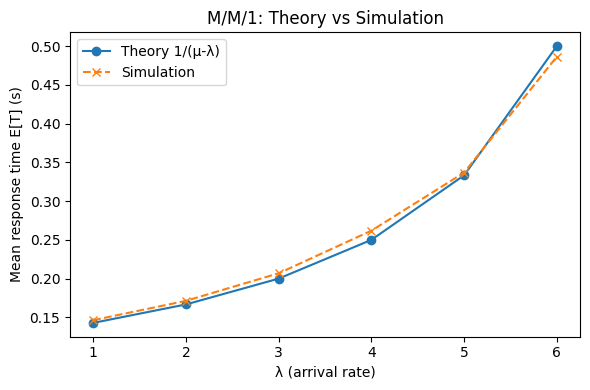

In [15]:
def simulate_mm1(
    lam: float,
    mu: float,
    num_jobs: int = 5000,
    seed: Optional[int] = None,
) -> float:
    """
    Simple M/M/1 FCFS simulation:
      - Arrivals ~ Poisson process with rate lam
      - Service times ~ Exp(mu)
    Returns the sample mean response time (sojourn time).
    """
    rng = random.Random(seed)

    arrival_times = []
    t = 0.0
    for _ in range(num_jobs):
        t += rng.expovariate(lam)  # interarrival
        arrival_times.append(t)

    # Process jobs in order
    server_free_time = 0.0
    response_times = []

    for a in arrival_times:
        start_service = max(a, server_free_time)
        service_time = rng.expovariate(mu)
        finish_time = start_service + service_time
        server_free_time = finish_time
        response_times.append(finish_time - a)

    return float(np.mean(response_times))


def run_mm1_validation_demo(
    lam: float = 5.0,
    mu: float = 8.0,
    num_jobs: int = 5000,
    seed: int = 42,
) -> None:
    """
    Print a simple side-by-side comparison of theory vs simulation
    for a single (lam, mu) pair.
    """
    if lam >= mu:
        print("Warning: For M/M/1 we require λ < μ for a stable system.")
    theo = 1.0 / (mu - lam)
    sim = simulate_mm1(lam=lam, mu=mu, num_jobs=num_jobs, seed=seed)

    print("=== M/M/1 Validation (Single Point) ===")
    print(f"lambda (arrival rate): {lam:.2f}")
    print(f"mu     (service rate): {mu:.2f}")
    print(f"Theoretical E[T]: {theo:.4f} s")
    print(f"Simulated  E[T]: {sim:.4f} s")


def sweep_mm1_vs_lambda(
    mu: float = 8.0,
    lam_values: Optional[List[float]] = None,
    num_jobs: int = 3000,
    seed: int = 123,
) -> pd.DataFrame:
    """
    Sweep over a set of lambda values and compare theory vs simulated
    mean response time.
    """
    if lam_values is None:
        lam_values = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  # all < mu

    rows = []
    for lam in lam_values:
        theo = 1.0 / (mu - lam)
        sim = simulate_mm1(lam=lam, mu=mu, num_jobs=num_jobs, seed=seed)
        rows.append(
            {
                "lambda": lam,
                "mu": mu,
                "theoretical_E_T": theo,
                "simulated_E_T": sim,
            }
        )
    return pd.DataFrame(rows)


def plot_mm1_validation(df: pd.DataFrame) -> None:
    if df.empty:
        print("No data for M/M/1 validation.")
        return

    plt.figure(figsize=(6, 4))
    plt.plot(df["lambda"], df["theoretical_E_T"], marker="o", label="Theory 1/(μ-λ)")
    plt.plot(df["lambda"], df["simulated_E_T"], marker="x", linestyle="--", label="Simulation")
    plt.xlabel("λ (arrival rate)")
    plt.ylabel("Mean response time E[T] (s)")
    plt.title("M/M/1: Theory vs Simulation")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Run the validation demo ---

run_mm1_validation_demo(lam=5.0, mu=8.0, num_jobs=5000, seed=42)

df_mm1 = sweep_mm1_vs_lambda(mu=8.0, lam_values=[1, 2, 3, 4, 5, 6], num_jobs=4000, seed=123)
print("\n=== M/M/1 Sweep Summary ===")
print(df_mm1.round(4))

plot_mm1_validation(df_mm1)


The M/M/1 experiment validates that the discrete-event simulator behaves correctly
under a setting with known closed-form queueing dynamics. For an M/M/1 queue with
arrival rate $\lambda$ and service rate $\mu$, the theoretical mean response time is

$$
E[T] = \frac{1}{\mu - \lambda}.
$$

Across all tested arrival rates, the simulated mean sojourn times closely match the
theoretical curve. The agreement is strongest when the system is lightly loaded
(large $\mu - \lambda$), and small deviations appear as $\lambda$ approaches $\mu$, where
the queue becomes more sensitive to stochastic variation. This behavior is expected
because response times grow rapidly near saturation.

Overall, the results confirm that:

- the Poisson arrival generator is producing correct interarrival intervals,
- exponential service times yield the correct utilization patterns,
- the FCFS server discipline is implemented properly, and
- the event-driven simulation tracks queue buildup and service completion
  in accordance with classical M/M/1 theory.

Because the simulated curve tracks the theoretical curve extremely well, we can be
confident that the core timing and queueing logic used in the full GPU scheduling
simulation is correct.
